<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/python/spatial_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Térinformatikai programozás Python-ban

### Szükséges Python csomagok és adatállományok

In [ ]:
!pip install -q rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.5 MB/s eta 0:00:00


In [ ]:
!wget -q http://www.agt.bme.hu/~siki/ullo/odm_orthophoto_25.tif
!wget -q http://www.agt.bme.hu/ftp/foss/mo.zip
!unzip -q mo.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull
import rasterio
import rasterio.plot
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import rasterio

## Geometriai számítás

Pontok a háromszögben: 11.0% 11 / 100
Háromszög területe: 0.1
Háromszög kerülete: 1.3


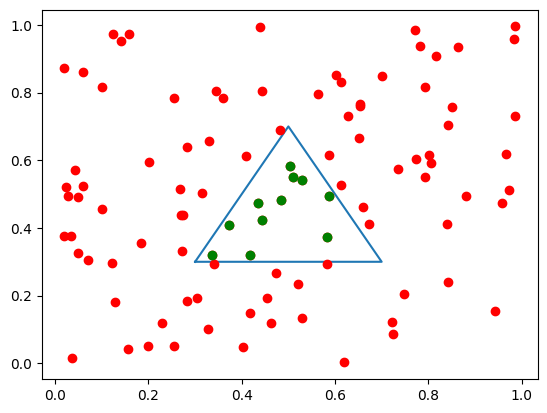

In [ ]:
# Create a point and a polygon
coords = ((0.3, 0.3), (0.7, 0.3), (0.5, 0.7), (0.3, 0.3))
poly = Polygon(coords)
inside = 0
points_inside = []
for point in points:
    if poly.contains(Point(point)):
        points_inside.append(point)
        inside += 1
p_ins = np.array(points_inside)
plt.plot(*poly.exterior.xy)
plt.plot(points[:,0], points[:,1], 'ro')
plt.plot(p_ins[:,0], p_ins[:,1], 'go')
print(f"Pontok a háromszögben: {inside / len(points) * 100:.1f}% {inside} / {len(points)}")
print(f"Háromszög területe: {poly.area:.1f}")
print(f"Háromszög kerülete: {poly.length:.1f}")

## Világtérkép megjelenítése

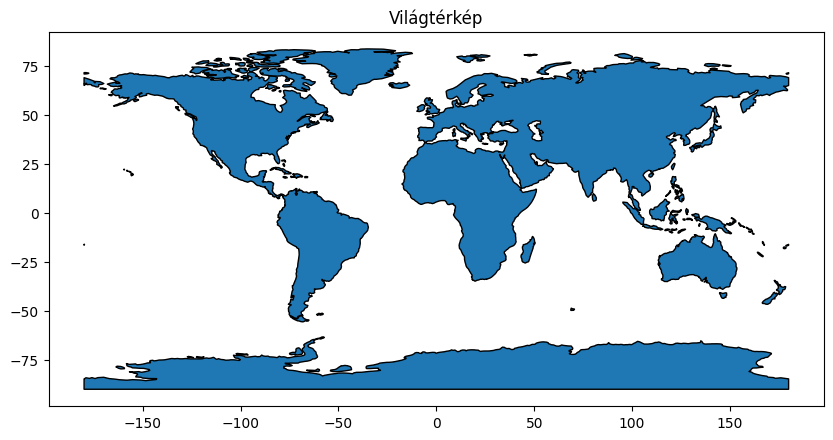

In [ ]:
url = "http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
df = gpd.read_file(url)

# Plot the world map
df.plot(figsize=(10, 6), edgecolor='black')
_ = plt.title("Világtérkép")

Text(0.5, 1.0, 'Részlet')

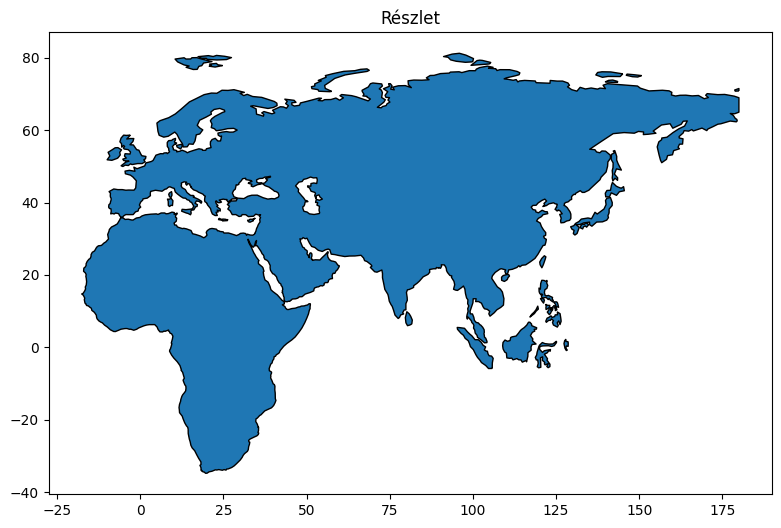

In [ ]:
box = (-10, 0.0, 180.0, 80.0)
df1 = gpd.read_file(url, bbox=box)  # csak a teljesen beleesők
df1.plot(figsize=(10, 6), edgecolor='black')
plt.title("Részlet")

## Interaktív térkép

In [ ]:
# térkép Budapest középponttal
m = folium.Map(location=[47.498, 19.040], zoom_start=10)
# jelek hozzáadása
folium.Marker(location=[47.498, 19.040], popup="Budapest").add_to(m)
folium.Marker(location=[47.4819, 19.0544], popup="Foszforgézu").add_to(m)
# megjelenítés Jupyter jegyzettömbben
m

## Koordináta átszámítás

In [ ]:
from pyproj import Transformer

# ETRS -> EOV
transformer = Transformer.from_crs("EPSG:4258", "EPSG:23700", always_xy=True)
x, y = transformer.transform(19.05652985, 47.48094377)  # BUTE permanens állomás
print(f"EOV koordináták: {x:.2f} {y:.2f}")


EOV koordináták: 650684.60 237444.25


## Térbeli összekapcsolás

Melyik város melyik megyébe esik

In [ ]:
cities = gpd.read_file('varos.shp')
counties = gpd.read_file('megye.shp')

joined = gpd.sjoin(cities, counties, how="left", predicate='within')

print(joined[['NEV', 'Nev']])

                 NEV                     Nev
0             Sopron       Gyõr-Moson-Sopron
1               Gyõr       Gyõr-Moson-Sopron
2        Szombathely                     Vas
3       Zalaegerszeg                    Zala
4               Pécs                 Baranya
5          Szekszárd                   Tolna
6           Veszprém                Veszprém
7          Tatabánya       Komárom-Esztergom
8     Székesfehérvár                   Fejér
9           Budapest                Budapest
10         Kecskemét             Bács-Kiskun
11       Salgótarján                  Nógrád
12           Szolnok    Jász-Nagykun-Szolnok
13            Szeged                Csongrád
14  Hódmezõvásárhely                Csongrád
15              Eger                   Heves
16           Miskolc    Borsod-Abaúj-Zemplén
17       Nyíregyháza  Szabolcs-Szatmár-Bereg
18          Debrecen             Hajdú-Bihar
19        Békéscsaba                   Békés
20          Kaposvár                  Somogy


## Réteg vágása egy másik réteggel

Városok egy megyében.

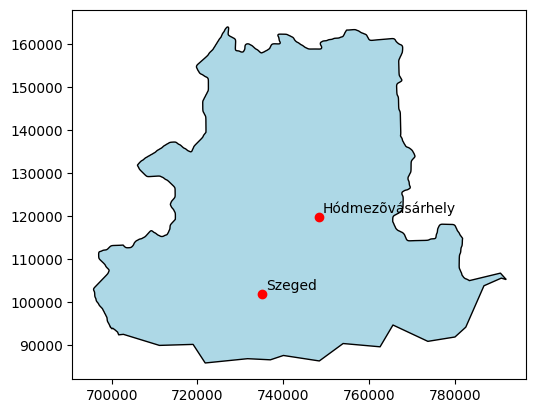

In [ ]:
# Select one country (e.g., France)
csongrad = counties[counties['Nev']=='Csongrád']

# Clip cities to the France boundary
cities_in_csongrad = gpd.clip(cities, csongrad)

# Plot
base = csongrad.plot(color='lightblue', edgecolor='black')
cities_in_csongrad.plot(ax=base, color='red')
for x, y, label in zip (cities_in_csongrad.geometry.x, cities_in_csongrad.geometry.y, cities_in_csongrad['NEV']):
    plt.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

## Övezetkészítés

Folyók 10 km-es környezete

Text(0.5, 1.0, 'Folyók övezetei')

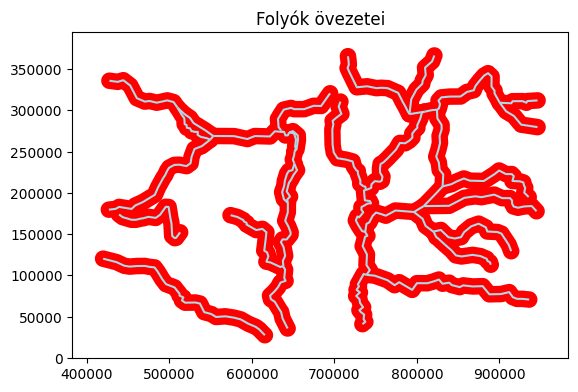

In [ ]:
rivers = gpd.read_file('folyo.shp')
buffer = rivers.buffer(10000)
base = rivers.plot(color='lightblue', edgecolor='black')
buffer.plot(ax=base, color='red')
base.set_title("Folyók övezetei")

## Delaunay háromszögek generálása

### Háromszögrács generálása

In [ ]:
points = np.random.rand(100, 2)
triangles = Delaunay(points)

### Konvex befoglaló idom a pontokra

In [ ]:
hull = ConvexHull(points)

### Háromszögrács és konvex befoglaló idom megjelenítése

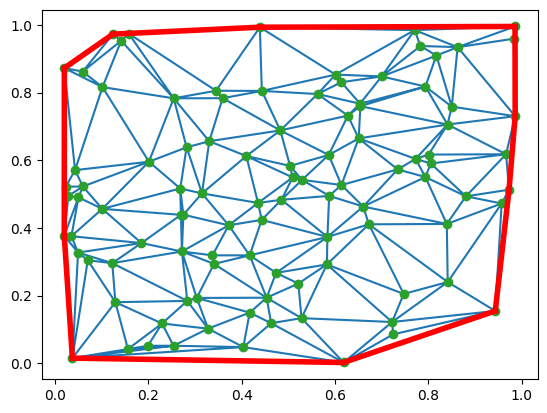

In [ ]:
plt.triplot(points[:,0], points[:,1], triangles.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'r-', linewidth=4)

##Raszter betöltése és megjelenítése

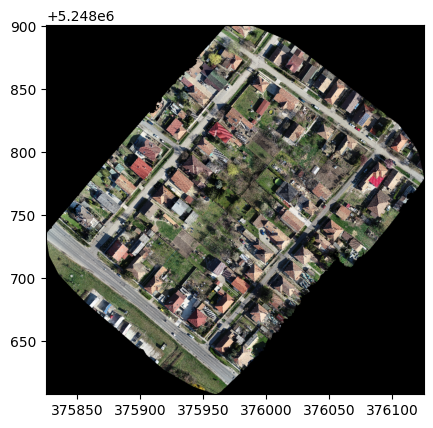

1199 x 1174 x 4 sáv
Határok: 375825.20 5248607.95 376124.96 5248901.43
Vetület: EPSG:32634


In [ ]:
with rasterio.open('odm_orthophoto_25.tif') as src:
    rasterio.plot.show(src)
    print(f"{src.width} x {src.height} x {len(src.indexes)} sáv")
    print(f"Határok: {src.bounds.left:.2f} {src.bounds.bottom:.2f} {src.bounds.right:.2f} {src.bounds.top:.2f}")
    print(f"Vetület: {src.crs}")

## Raszter kalkulációk

Átlag: 2.84, Szórás: 4.58, Min: 0.00, Max: 273.56


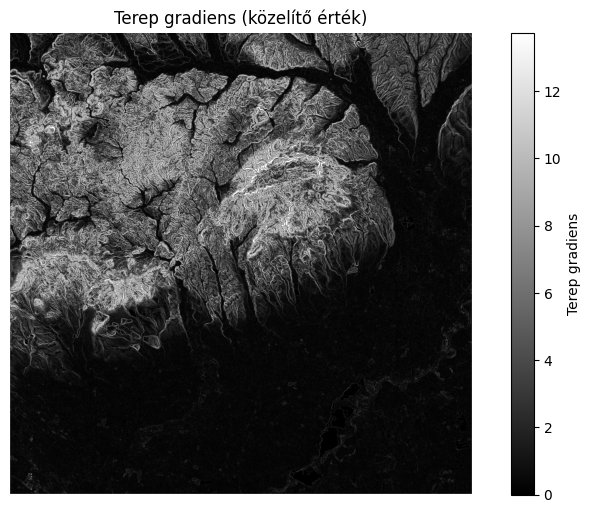

In [ ]:
with rasterio.open('matra.tif') as src:
    dem = src.read(1).astype('float32')  # Sáv 1: magasság

dem[dem == src.nodata] = np.nan
mean_val = np.nanmean(dem)
std_val = np.nanstd(dem)
min_val = np.nanmin(dem)
max_val = np.nanmax(dem)

#print(f"Átlag: {mean_val:.2f}, Szórás: {std_val:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

up = np.roll(dem, -1, axis=0)
down = np.roll(dem, 1, axis=0)
left = np.roll(dem, -1, axis=1)
right = np.roll(dem, 1, axis=1)
slope_like = np.sqrt(((up - down)**2 + (left - right)**2) / 2)
slope_like[np.isnan(dem)] = np.nan
mean_val = np.nanmean(slope_like)
std_val = np.nanstd(slope_like)
min_val = np.nanmin(slope_like)
max_val = np.nanmax(slope_like)
slope_like[slope_like > std_val * 3] = np.nan

print(f"Átlag: {mean_val:.2f}, Szórás: {std_val:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

plt.figure(figsize=(10, 6))
plt.imshow(slope_like, cmap='gray')
plt.colorbar(label='Terep gradiens')
plt.title("Terep gradiens (közelítő érték)")
_ = plt.axis('off')